In [1]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

## 1. Load data

In [2]:
df_train = pd.read_csv("../data/titanic/train.csv")
df_test = pd.read_csv("../data/titanic/train.csv")

In [3]:
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 2. Quick EDA

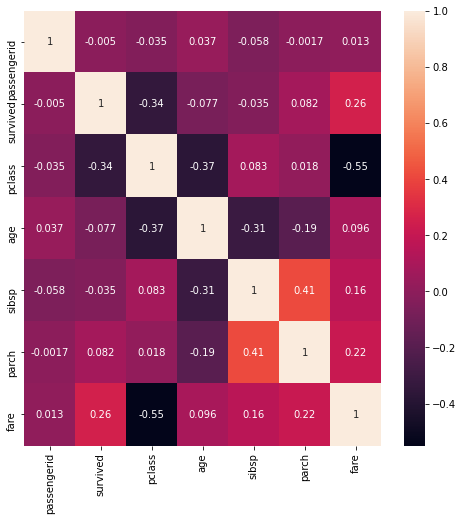

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_train.corr(), annot=True, ax=ax);

## 3. Preprocess features

In [7]:
class MyImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        
        self.columns = kwargs.pop("columns")
        self.kwargs = kwargs
        
    def fit(self, X, y= None):
        
        self.imputer = SimpleImputer(**self.kwargs)
        self.imputer.fit(X.loc[:, self.columns])
        return self
    
    def transform(self, X, y = None):
        if self.columns:
            X.loc[:, self.columns] = self.imputer.transform(X.loc[:, self.columns])
        return X

In [8]:
class AgeImputer(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y = None):
        self.medians = X.groupby(["pclass","sex"])["age"].median()
        return self

    def transform(self, X):
        X.loc[X.age.isnull(), "age"] = X.loc[X.age.isnull(), :]\
            .apply(lambda x: self.medians.loc[(x.pclass, x.sex)], axis=1)
        return X

In [9]:
class MyHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        
        self.column = [kwargs.pop("column")]
        self.kwargs = kwargs
        
    def fit(self, X, y= None):
        
        self.encoder = OneHotEncoder(**self.kwargs)
        self.encoder.fit(X.loc[:, self.column])
        return self
    
    def transform(self, X, y = None):
        
        data = self.encoder.transform(X.loc[:, self.column])
        encoded = pd.DataFrame(
            data = data, 
            columns=[f"{self.column[0]}_{cat}" for cat in self.encoder.categories_[0] ])
        return pd.concat([X, encoded], axis = 1).drop(self.column, axis = 1)

In [10]:
# credits to https://gist.github.com/EikeDehling/90404aed7de3746162595be161109ef3 
class TitleAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.mapping = {
            "Capt": "officer",
            "Col": "officer",
            "Major": "officer",
            "Dr": "officer",
            "Rev": "officer",
            "Master" : "officer",
            "Jonkheer": "royal",
            "Don": "royal",
            "Sir" : "royal",
            "the Countess":"royal",
            "Lady" : "royal",
            "Mr" : "mr",
            "Mme": "mrs",
            "Ms": "mrs",
            "Mrs" : "mrs",
            "Mlle": "miss",
            "Miss" : "miss",        
        }
        
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X["title"] = X.loc[:, "name"].str.split(",").\
            apply(pd.Series)[1].str.split(".").apply(lambda x: x[0]).str.strip()
        X["title"] = X["title"].replace(self.mapping)
        return X

In [11]:
class FamilyAdder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X["family"] = X["sibsp"] + X["parch"] + 1 
        return X

In [12]:
class CabinTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X.loc[:, "cabin"] = X["cabin"].map(lambda c: c[0])    
        return X

In [24]:
class FareBinner(BaseEstimator, TransformerMixin):
        
    def fit(self, X, y = None):
        qcut = pd.qcut(X["fare"], q=4, precision = 4)
        self.bins = qcut.cat.categories
        self.mapping = { bin:value for value, bin in enumerate(self.bins,1) }
        return self

    def transform(self, X):
        X.loc[:, "fare"] = pd.cut(X["fare"], bins = self.bins)
        X.loc[:, "fare"] = X.loc[:, "fare"].map(self.mapping)
        return X

In [25]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def __init__(self, to_drop):
        self.to_drop = to_drop
    
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        return X.drop(self.to_drop, axis = 1)

In [26]:
preprocess_pipe = Pipeline([
    ("age_imputer", AgeImputer()),
    ("cat_imputer", MyImputer(strategy = "constant", fill_value = "X", columns = ["cabin","embarked"])),
    ("title_adder", TitleAdder()),
    ("family_adder", FamilyAdder()),
    ("cabin_transformer", CabinTransformer()),
    ("fare_binner", FareBinner()),
    ("sex_encoder", MyHotEncoder(column = "sex", handle_unknown = "ignore", sparse = False)),
    ("cabin_encoder", MyHotEncoder(column = "cabin", handle_unknown = "ignore", sparse = False)),
    ("embarked_encoder", MyHotEncoder(column = "embarked", handle_unknown = "ignore", sparse = False)),
    ("title_encoder", MyHotEncoder(column = "title", handle_unknown = "ignore", sparse = False)),
    ("feature_dropper", FeatureDropper(["name","ticket","passengerid"]))
])

## 4. Build datasets

In [27]:
X_train = preprocess_pipe.fit_transform(df_train.drop("survived", axis=1))
y_train = df_train["survived"]

X_test  = preprocess_pipe.transform(df_test.drop("survived", axis=1))
y_test  = df_test["survived"]

## 5. Implement classifier

In [29]:
n_estimators = range(50,525,25)
max_depth = range(2,21)
min_samples_split = range(10,105,5)
min_samples_leaf = range(10,11) 

param_dist = dict(
    n_estimators = n_estimators, 
    max_depth = max_depth,  
    min_samples_split = min_samples_split, 
    min_samples_leaf = min_samples_leaf,
)

In [30]:
inner_cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
outer_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

search = RandomizedSearchCV(
    estimator = RandomForestClassifier(random_state = 42), 
    param_distributions = param_dist, 
    cv = inner_cv,
    scoring="f1",
    n_iter = 100
)

search.fit(X_train, y_train)
    
nested_score = cross_val_score(search, X = X_train, y = y_train, cv = outer_cv)
nested_score

array([0.78787879, 0.80597015, 0.67741935, 0.72727273, 0.73684211,
       0.6984127 , 0.83076923, 0.73015873, 0.8358209 , 0.73239437])

In [31]:
nested_score.mean()

0.7562939045567344

In [32]:
search.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_depth': 9}

## 5. Test classifier

In [33]:
accuracy_score(y_test, search.best_estimator_.predict(X_test))

0.8361391694725028